In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data

I created an entrapment exeperiment as follows. 

A Pfu sample containing 15365 Pfu MS2 spectra was searched against a fasta file that contains 2045 Pfu proteins and 185245 Eukaryote and Vertebrate proteins. All reviewed Uniprot entries.

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

In [37]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
dataset = "PXD001468"

 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [38]:

folder2 = folder + "/" + dataset
ionbot = pd.read_csv("%s/ionbot.first.csv"%folder2)
ionbot["rank"] = ["first"]*len(ionbot)
tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
tmp["rank"] = ["lower"]*len(tmp)
ionbot = pd.concat([ionbot,tmp])
tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")

Filter for identified (co-eluting) matches.

In [39]:
print(len(ionbot))
ionbot = ionbot[(ionbot["database"]=="T")&(ionbot["q-value"]<0.01)]
print(len(ionbot))

1507944
739009


In [40]:
folder2 = folder + "/" + dataset + "_A"
ionbot_A = pd.read_csv("%s/ionbot.first.csv"%folder2)
ionbot_A["rank"] = ["first"]*len(ionbot_A)
tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
tmp["rank"] = ["lower"]*len(tmp)
ionbot_A = pd.concat([ionbot_A,tmp])
tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
ionbot_A = ionbot_A.merge(tmp,on="ionbot_match_id",how="left")

In [41]:
ionbot_A = ionbot_A[(ionbot_A["database"]=="T")&(ionbot_A["q-value"]<0.01)]

In [42]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

print(len(ionbot_A))
ionbot_A["contains_missed_cleavage"] = ionbot_A["matched_peptide"].apply(contains_missed_cleavage)    
ionbot_A["num_passed"] = ionbot_A.groupby(["spectrum_title"])["spectrum_title"].transform("count")
print(ionbot_A["num_passed"].value_counts())
ionbot_A = ionbot_A[(ionbot_A["num_passed"]==1) |
        (ionbot_A["rank"]=="lower") |
        ((ionbot_A["num_passed"]>1) & (ionbot_A["rank"]=="first") & (ionbot_A["unexpected_modification"].isna()) & (ionbot_A["contains_missed_cleavage"]==False))]
print(len(ionbot_A))
#need to re-assign best_psm
best_psms = ionbot_A.sort_values("psm_score").drop_duplicates("spectrum_title", keep="last")
best_psm_ids = set(best_psms["ionbot_match_id"])
ionbot_A["rank"] = ionbot_A["ionbot_match_id"].apply(
    lambda x: "first" if x in best_psm_ids else "lower"
)


718136
1    649831
2     65620
3      2613
4        72
Name: num_passed, dtype: int64
709270


In [43]:
def is_target(x):
    tmp = x.split('||')
    for t in tmp:
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

ionbot_A["is_target"] = ionbot_A["proteins"].apply(is_target)

In [44]:
tmp1 = ionbot_A[ionbot_A["rank"]=="first"].sort_values("q-value")
tmp2 = ionbot_A[ionbot_A["rank"]=="lower"].sort_values("q-value")

<Figure size 1728x1728 with 0 Axes>

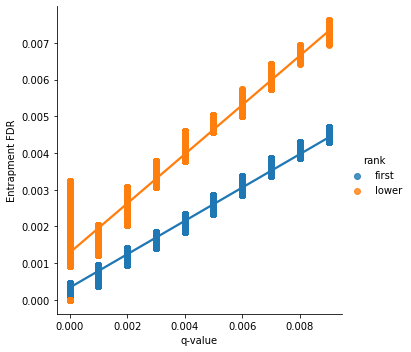

In [45]:
l1 = list(tmp1["is_target"])
l2 = list(tmp1["q-value"])
X = []
c = 0
for i in range(len(l1)):
    if l2[i] > 0.05: break
    if l1[i] == False:
        c += 1
    X.append([l2[i],c/(i+1)])
d1 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
d1["rank"] = ["first"]*len(d1)
l1 = list(tmp2["is_target"])
l2 = list(tmp2["q-value"])
X = []
c = 0
for i in range(len(l1)):
    if l2[i] > 0.05: break
    if l1[i] == False:
        c += 1
    X.append([l2[i],c/(i+1)])
d2 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
d2["rank"] = ["lower"]*len(d2)
d = pd.concat([d1,d2])

plt.figure(figsize=(24,24))
sns.lmplot(x="q-value",y="Entrapment FDR",hue="rank",data=d,fit_reg=True)


Let's do this for msfragger as well.

In [46]:
fragger = pd.read_csv("%s/msfragger/%s_A/psm.tsv"%(folder,dataset),sep="\t")
fragger["proteins_all"] = fragger["Protein"].astype(str) + ',' + fragger["Mapped Proteins"].astype(str)

In [47]:
len(fragger)

739677

In [48]:
def is_target2(x):
    tmp = x.split(',')
    for t in tmp:
        if t == "nan":
            continue
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

In [49]:
fragger["is_target"] = fragger["proteins_all"].apply(is_target2)
fragger["is_target"].value_counts()

True     739461
False       216
Name: is_target, dtype: int64

In [50]:
c = 0
e = 0
X = []
with open("%s/msfragger/%s_A/o"%(folder,dataset)) as f:
    f.readline()
    for row in f:
        l = row.rstrip().split('\t')
        if float(l[2]) > 0.02: break
        c += 1
        ok = False
        for t in l[5:]:
            if not "ENTRAPMENT" in t:
                ok = True
        if ok == False:
            e += 1
        X.append([float(l[2]),e / c])
d = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])

Now, let's look at proteins.

In [51]:
fraggerP = pd.read_csv("%s/msfragger/protein.tsv"%folder,sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: '/home/compomics/tools/ionbot_paper/msfragger/protein.tsv'

In [ ]:
fraggerP["is_pyrfu"] = fraggerP["Protein"].apply(is_pyrfu)
fraggerP["is_pyrfu"].value_counts()

True     782
False     40
Name: is_pyrfu, dtype: int64

In [ ]:
fraggerP["is_cont"] = fraggerP["Entry Name"].apply(is_cont)
fraggerP["is_cont"].value_counts()

False    820
True       2
Name: is_cont, dtype: int64

At the protein level this makes much more of a difference!:

In [ ]:
print(len(fraggerP))
print(len(fraggerP[(fraggerP["is_pyrfu"]==False)&(fraggerP["is_cont"]==False)]))

822
38


In [ ]:
def get_scan_ionbot(x):
    return x.split('_')[1]
ionbot["scan"] = ionbot["ionbot_match_id"].apply(get_scan_ionbot)

In [ ]:
def get_scan_msfrageer(x):
    return str(int(x.split('.')[-2])-1)
fragger["scan"] = fragger["Spectrum"].apply(get_scan_msfrageer)

In [ ]:
def replace_L_I(x):
    return x.replace("L","I")

ionbot["PSM"] = ionbot["scan"] + ionbot["database_peptide"].apply(replace_L_I)
fragger["PSM"] = fragger["scan"] + fragger["Peptide"].apply(replace_L_I)

#### Let's first focus on spectra with co-eluting matches.


In [ ]:
ionbot["num_matches"] = ionbot.groupby("scan")["scan"].transform("size")
tmp = ionbot[ionbot["num_matches"]>1]
#tmp = ionbot[(ionbot["rank"]=="first")&(ionbot["false"]==True)]
ionbot["num_matches"].value_counts()

1    10537
2      414
3       15
Name: num_matches, dtype: int64

I select those spectra that have a non-pyrfu match.

In [ ]:
#tmp = tmp[tmp["false"]==True]
len(tmp["scan"].unique())

212

In [ ]:
tmp["scan"].value_counts().value_counts()

2    207
3      5
Name: scan, dtype: int64

In [ ]:
tmp.columns

Index(['ionbot_match_id', 'spectrum_title', 'scan', 'spectrum_file',
       'precursor_mass', 'peptide_mass', 'observed_retention_time', 'charge',
       'database_peptide', 'matched_peptide', 'modifications',
       'modifications_delta', 'best_tag_rank', 'corrected_retention_time',
       'unexpected_modification', 'database', 'psm_score', 'q-value', 'PEP',
       'proteins', 'rank', 'by-count', 'all-count', 'by-explained',
       'all-explained', 'by-intensity-pattern-correlation',
       'predicted_retention_time', 'rt-pred-error',
       'has_unexpected_modification', 'contains_missed_cleavage',
       'match_count', 'peplen', 'best_psm', 'is_cont', 'is_pyrfu', 'false',
       'PSM', 'num_matches'],
      dtype='object')

In [ ]:
tmp_w = tmp[["scan","spectrum_title","database_peptide","matched_peptide","modifications","false","rank","proteins","by-count","psm_score","by-intensity-pattern-correlation"]]
frag_w = fragger[["scan","Peptide","Entry Name"]]
d = tmp_w.merge(frag_w,on="scan",how="left")
d["Peptide"] = d["Peptide"].fillna('-').apply(replace_L_I)
d["same_peptide"] = (d["matched_peptide"] == d["Peptide"])
d["same_peptide_count"] = d.groupby("scan")["same_peptide"].transform("sum")
d.to_csv("d.csv",index=False)

In [ ]:
tmp.to_csv("euh.csv",index=False)

In [ ]:
s1 = set(ionbot["PSM"].values)
s2 = set(fragger["PSM"].values)

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

1571
9395
972


In [ ]:
d = ionbot.merge(fragger,on="scan")

In [ ]:
d["same_peptide"] = (d["database_peptide"] == d["Peptide"])

In [ ]:
d[d["same_peptide"]==False].to_csv("diff_pep.csv",index=False)

In [ ]:
len(d[d["same_peptide"]==False])

7176

# Conclusion

- all co-eluting matches (+- 10%) found in ionbot were Pfu or contaminant
- msfragger does identify some entrapment PSMs (0.5%, as reported in the open-pfind paper as well), with large impact on the protein inference.